In [181]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl

import logging
logging.basicConfig(level=logging.INFO)

In [182]:
def rho_w(T):#density of water kg/m3 at T deg C
    #10.1088/0026-1394/38/4/3
    a = [-3.983035,301.797,522528.9,69.34881,999.97495]
    return a[4]*(1-(T+a[0])**2*(T+a[1])/a[2]/(T+a[3]))
def latent(T):#latent heat of vaporization kJ/kg at T deg C
    return 2501 - 0002.361 * T

In [183]:
cook_flux = pd.read_csv('../../work/CafMeteorologyECTower/REddyProc/CookEast/6503_20231017_REP_output.txt',skiprows=[1,2],sep='\t').replace(to_replace=-9999,value=np.nan)

In [184]:
cook_hy2023_v1 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cookhy2023V1_batch_output.csv')
cook_hy2023_v2 = pd.read_csv('E:/usda/work/CookIRCamET/Working/cookhy2023V2_batch_output.csv')
cook_hy2023 = pd.concat([cook_hy2023_v1,cook_hy2023_v2]).astype({'times':'datetime64'}).reset_index()

In [185]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Rg', 'Tair', 'rH', 'LE_uStar_f', 'LE_uStar_fqc']]
cook_flux['lambda']=cook_flux.Tair.apply(latent)
cook_flux['rho_w']=cook_flux.Tair.apply(rho_w)

In [186]:
cook_flux['ET']=cook_flux['LE_uStar_f']/cook_flux['lambda']/cook_flux['rho_w']*60*30#mm H20
cook_flux['Minutes']=60*(cook_flux['Hour']-np.floor(cook_flux['Hour']))

In [187]:
cook_flux['Hour']=np.floor(cook_flux['Hour'])

In [188]:
cook_flux = cook_flux[['Year', 'DoY', 'Hour', 'Minutes', 'Rg', 'Tair', 'rH', 'ET']]

In [189]:
cook_flux['times']=pd.to_datetime(cook_flux['Year'].astype(str) + ' ' + cook_flux['DoY'].astype(str) + ' ' + cook_flux['Hour'].astype(int).astype(str)+':'+cook_flux['Minutes'].astype(int).astype(str),
    format='%Y %j %H:%M'
   )

In [190]:
cook_flux=cook_flux.groupby(['Year','DoY','Hour']).agg({'times':'max', 'Rg':'mean', 'Tair':'mean', 'rH':'mean', 'ET':'mean'}).reset_index()

In [191]:
cook_hy2023['times'] = cook_hy2023.times.dt.tz_localize('UTC')

In [192]:
cook_flux['times'] = cook_flux.times.dt.tz_localize('Etc/GMT-8')

In [193]:
cook_flux['times'] = cook_flux.times.dt.tz_convert('UTC')

In [194]:
xlim=[pd.to_datetime('2023-06-15 00:00:00',format='%Y-%m-%d %H:%M:%S'),pd.to_datetime('2023-06-30 00:00:00',format='%Y-%m-%d %H:%M:%S')]

<AxesSubplot:xlabel='times'>

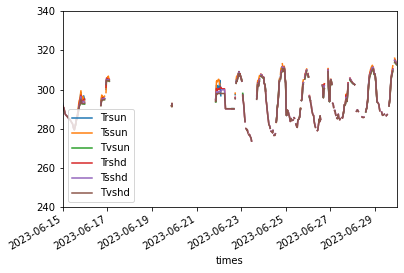

In [195]:
cook_hy2023.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=xlim,ylim=[240,340])

<AxesSubplot:xlabel='times'>

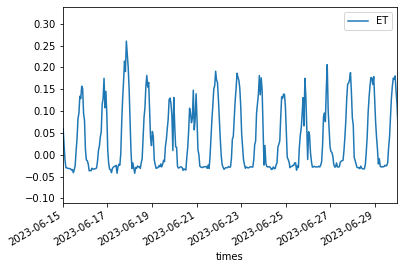

In [196]:
cook_flux.plot(x='times',y=['ET'],xlim=xlim)

In [197]:
cook_hy2023['times2']=cook_hy2023['times']
for i in cook_hy2023.index:
    mask = abs(cook_hy2023.loc[i,'times']-cook_flux['times'])==min(abs(cook_hy2023.loc[i,'times']-cook_flux['times']))
    cook_hy2023.loc[i,'times2'] = cook_flux.loc[mask,'times'].values[0]

In [198]:
cook_hy2023.loc[i,'times']

Timestamp('2023-07-18 16:21:58+0000', tz='UTC')

In [199]:
cook_hy2023 = cook_hy2023.drop(columns=['times'])

In [208]:
cook_hy2023 = cook_hy2023.rename(columns={'times2':'times'}).drop(columns=['index', 'Unnamed: 0'])

In [213]:
cook_hy2023['times'] = cook_hy2023.astype({'times':'datetime64'}).reset_index().times.dt.tz_localize('UTC')

In [242]:
cook_flux = cook_flux.merge(cook_hy2023,how='right')
cook_flux=cook_flux[cook_flux.times>=cook_hy2023.times.min()]
cook_flux=cook_flux[cook_flux.times<=cook_hy2023.times.max()]

In [215]:
inputs = ['elevation', 'azimuth', 'fssun',
       'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd', 'Tssun',
       'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd']
outputs = ['ET']

In [243]:
for i in inputs:
    cook_flux.loc[:,i]=cook_flux[i].interpolate(method='cubicspline')

In [229]:
cook_flux.to_csv('E:usda/work/CookIRCamET/Working/cook_hy2023_ec.csv',index=False)

In [218]:
n_in = len(inputs)

In [236]:
features = cook_flux[inputs].values
et = cook_flux[outputs].values

In [237]:
features

array([[7.36038133e+01, 2.28433692e+02, 1.91487630e-01, ...,
        9.19055639e+00,            nan,            nan],
       [7.76268462e+01, 2.34731851e+02, 1.18217773e-01, ...,
        2.83708788e+02, 2.83020742e+02, 2.83117759e+02],
       [8.19525192e+01, 2.40706896e+02, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       ...,
       [5.15683364e+01, 1.00161487e+02, 8.46824363e-03, ...,
        2.95589595e+02,            nan,            nan],
       [5.07114881e+01, 1.01221610e+02, 8.60604745e-03, ...,
                   nan,            nan,            nan],
       [4.98605714e+01, 1.02295486e+02, 8.30078125e-03, ...,
        2.96072599e+02,            nan,            nan]])

In [234]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.random.set_seed(42)

model = Sequential()
model.add(Input(shape=(None,n_in)))
model.add(LSTM(n_in, return_sequences=True))
model.add(Dense(6,activation='relu'))
model.add(Dense(1))

In [235]:
model.build()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 18)          2664      
_________________________________________________________________
dense_8 (Dense)              (None, None, 6)           114       
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           7         
Total params: 2,785
Trainable params: 2,785
Non-trainable params: 0
_________________________________________________________________
